## Yash Patel
### DS2500 Final Project - Green Line Reliability 
### Part 1: Data Wrangling + EDA
#### ____________________________________________________________________________________________________________________

### Sources:
#### Green Line CSV Data: “MBTA Rapid Transit Travel Times 2024” from Massachusetts geoDOT
#### https://mbta-massdot.opendata.arcgis.com/datasets/0b4dc16b8b984836962229865d5b573b/about
#### 
#### API for estimated travel time data: MBTA V3 API
#### https://www.mbta.com/developers/v3-api
##### Requests made with a valid API key are limited to a default of 1000 requests per minute.
#### ____________________________________________________________________________________________________________________

In [9]:
import pandas as pd
import requests
from time import sleep
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

FILEPATH = "/Users/ytpatel3/Downloads/TravelTimes_2024/"
FILENAMES = [FILEPATH + "2024-01_LRTravelTimes.csv", FILEPATH + "2024-02_LRTravelTimes.csv", FILEPATH + "2024-03_LRTravelTimes.csv",
             FILEPATH + "2024-04_LRTravelTimes.csv", FILEPATH + "2024-05_LRTravelTimes.csv", FILEPATH + "2024-06_LRTravelTimes.csv",
             FILEPATH + "2024-07_LRTravelTimes.csv", FILEPATH + "2024-08_LRTravelTimes.csv", FILEPATH + "2024-09_LRTravelTimes.csv"]

MONTHS = ["January","February","March","April","May","June","July","August","September"]

COLS = ["service_date", "route_id", "direction", "from_stop_id", "from_stop_name", "to_stop_id", "to_stop_name", "travel_time_sec"]
SUBLINES = ["Green-B","Green-C","Green-D","Green-E"]

API_KEY = "10d2647e0b794841bfadaf78c7ef2c8a"
BASE_URL = "https://api-v3.mbta.com"
RATE_LIMIT = 1000
BATCH_SIZE = RATE_LIMIT
BATCH_DELAY = 60 

#### Read CSVs into dataframes and add to 1 master dictionary

In [2]:
"""
- CSVs are large (about 3 million lines each) ---> need to get comprehensive sample
- Sample of 100,000 rows for each month
- 50,000 inbound, 50,000 outbound
- 12,500 for each of the 4 inbound sublines (B, C, D, E)
- 25,000 for each of the 2 outbound sublines (D, E)
"""

data_dct = {}

for i in range(len(FILENAMES)):
    temp = pd.read_csv(FILENAMES[i], usecols=COLS, low_memory=False)
    cleaned = temp.dropna()

    cleaned['from_stop_id'] = cleaned['from_stop_id'].astype(str)
    cleaned['to_stop_id'] = cleaned['to_stop_id'].astype(str)

    inbound_data = cleaned[cleaned["direction"]=="West"]
    outbound_data = cleaned[cleaned["direction"]=="East"]

    inbound_sample = []
    for subline in SUBLINES:
        subline_data = inbound_data[inbound_data["route_id"]==subline]
        sample_subline_data = subline_data.sample(n=12500, random_state=42)
        inbound_sample.append(sample_subline_data)

    outbound_sample = []
    for subline in SUBLINES[2:]:
        subline_data = outbound_data[outbound_data["route_id"]==subline]
        sample_subline_data = subline_data.sample(n=25000, random_state=42)
        outbound_sample.append(sample_subline_data)

    sample = pd.concat(inbound_sample + outbound_sample).reset_index(drop=True)
    data_dct[MONTHS[i]] = sample

#### Create a new column in the dataframes that holds the estimated travel time via Google Maps 

In [3]:
# Cache to store unique stop pairs and their travel times
travel_time_cache = {}

In [4]:
def fetch_travel_time(from_stop_id, to_stop_id):
    """Fetch estimated travel time from MBTA API."""
    url = f"{BASE_URL}/predictions"
    params = {
        "filter[stop]": f"{from_stop_id},{to_stop_id}",
        "api_key": API_KEY,
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        travel_times = []
        for item in data.get('data', []):
            arrival_time_str = item['attributes'].get('arrival_time')
            departure_time_str = item['attributes'].get('departure_time')
            
            if arrival_time_str and departure_time_str:
                # Convert strings to datetime objects
                arrival_time = datetime.fromisoformat(arrival_time_str.replace('Z', '+00:00'))
                departure_time = datetime.fromisoformat(departure_time_str.replace('Z', '+00:00'))
                
                travel_time_seconds = (arrival_time - departure_time).total_seconds()
                travel_times.append(travel_time_seconds)
        
        return min(travel_times) if travel_times else None
    except Exception as e:
        print(f"Error fetching data for {from_stop_id} to {to_stop_id}: {e}")
        return None

In [5]:
def fetch_travel_time_with_cache(from_stop_id, to_stop_id):
    """Fetch travel time from cache or API."""
    key = (from_stop_id, to_stop_id)
    if key not in travel_time_cache:
        travel_time_cache[key] = fetch_travel_time(from_stop_id, to_stop_id)
    return travel_time_cache[key]

In [6]:
def add_travel_time_column_with_cache(df):
    """Add estimated travel time column to a DataFrame with caching and rate limiting."""
    travel_times = []
    total_rows = len(df)
    for i, row in df.iterrows():
        travel_time = fetch_travel_time_with_cache(row['from_stop_id'], row['to_stop_id'])
        travel_times.append(travel_time)

        # Check if batch size is reached
        if (i + 1) % BATCH_SIZE == 0:
            print(f"Processed {i + 1}/{total_rows} rows. Waiting for {BATCH_DELAY} seconds...")
            sleep(BATCH_DELAY)

    df['estimated_travel_time_sec'] = travel_times
    return df

In [7]:
for month, df in data_dct.items():
    print(f"Processing {month}...")
    data_dct[month] = add_travel_time_column_with_cache(df)

print("Travel times added!")

Processing January...
Processed 1000/100000 rows. Waiting for 60 seconds...
Processed 2000/100000 rows. Waiting for 60 seconds...
Processed 3000/100000 rows. Waiting for 60 seconds...
Processed 4000/100000 rows. Waiting for 60 seconds...
Processed 5000/100000 rows. Waiting for 60 seconds...
Processed 6000/100000 rows. Waiting for 60 seconds...
Processed 7000/100000 rows. Waiting for 60 seconds...
Processed 8000/100000 rows. Waiting for 60 seconds...
Processed 9000/100000 rows. Waiting for 60 seconds...
Processed 10000/100000 rows. Waiting for 60 seconds...
Processed 11000/100000 rows. Waiting for 60 seconds...
Processed 12000/100000 rows. Waiting for 60 seconds...
Processed 13000/100000 rows. Waiting for 60 seconds...
Processed 14000/100000 rows. Waiting for 60 seconds...
Processed 15000/100000 rows. Waiting for 60 seconds...
Processed 16000/100000 rows. Waiting for 60 seconds...
Processed 17000/100000 rows. Waiting for 60 seconds...
Processed 18000/100000 rows. Waiting for 60 seconds.

#### Save updated dataframes as CSVs for the Part 2 py file

In [35]:
downloads_path = '/Users/ytpatel3/Downloads'

for month, df in data_dct.items():
    df['service_date'] = pd.to_datetime(df['service_date'])
    df = df.sort_values(by='service_date').reset_index(drop=True)
    df['estimated_travel_time_sec'] = df['estimated_travel_time_sec'].astype(float).abs()
    df['travel_time_sec'] = df['travel_time_sec'].astype(float)
    print(df)

    file_path = os.path.join(downloads_path, f'{month}_green_line_data.csv')
    df.to_csv(file_path)

      service_date route_id direction from_stop_id         from_stop_name  \
0       2024-01-01  Green-D      West        70208  Science Park/West End   
1       2024-01-01  Green-E      West        70204              Haymarket   
2       2024-01-01  Green-B      West        70157              Arlington   
3       2024-01-01  Green-E      West        70510            Ball Square   
4       2024-01-01  Green-E      East        70246    Museum of Fine Arts   
...            ...      ...       ...          ...                    ...   
99995   2024-01-31  Green-C      West        70227       Fairbanks Street   
99996   2024-01-31  Green-B      West        71151                Kenmore   
99997   2024-01-31  Green-E      West        70202      Government Center   
99998   2024-01-31  Green-E      West        70245    Museum of Fine Arts   
99999   2024-01-31  Green-D      East        70154                 Copley   

      to_stop_id           to_stop_name  travel_time_sec  \
0          7018

#### Visualizations - Relationship between actual travel time and estimated travel time

#### Scatter Plots
##### Ideally, if the estimated values are close to the actual values, the points should align along the diagonal y=x

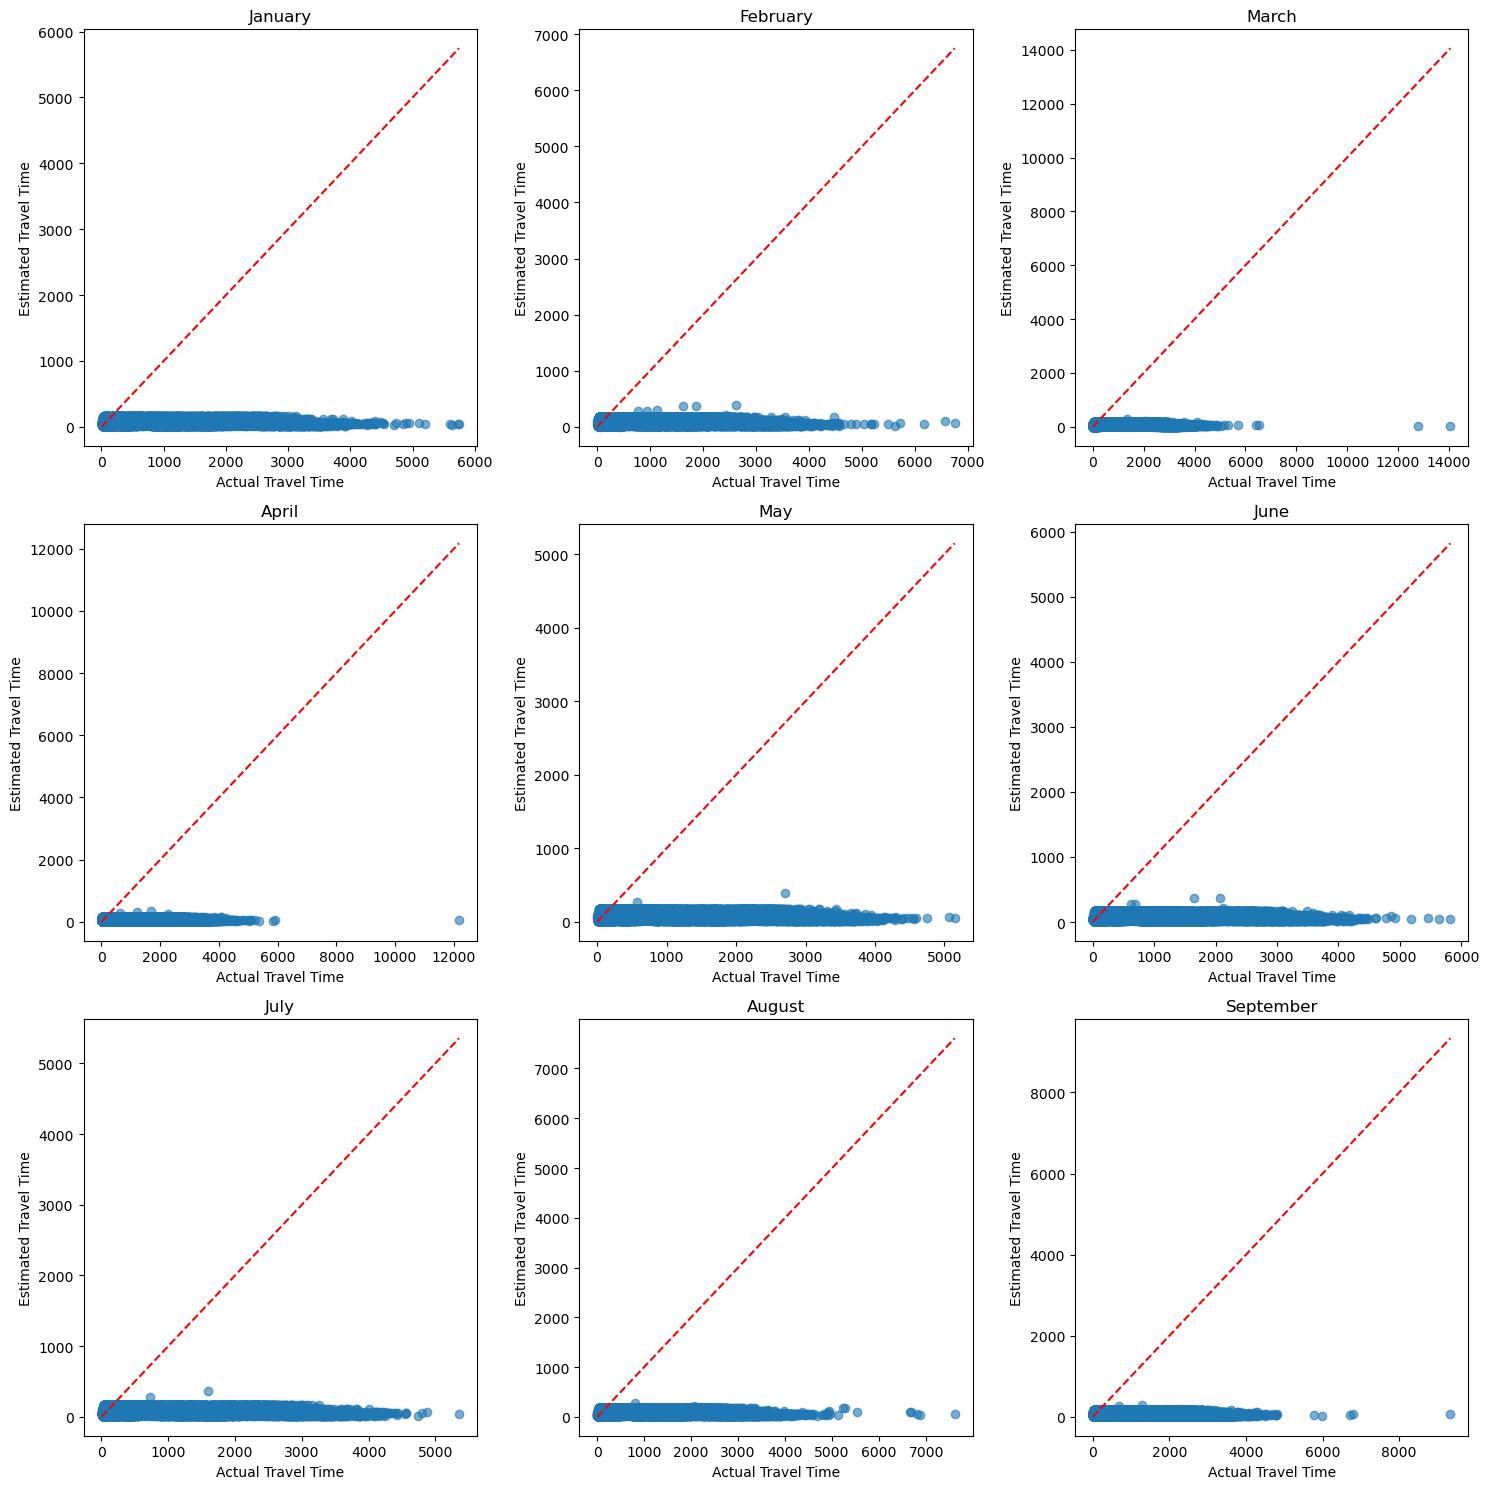

In [46]:
fig, axes = plt.subplots(3,3,figsize=(15,15))

for i, (month, df) in enumerate(data_dct.items()):
    ax = axes[i // 3, i % 3]
    ax.scatter(df['travel_time_sec'], df['estimated_travel_time_sec'], alpha=0.6)
    ax.plot([df['travel_time_sec'].min(), df['travel_time_sec'].max()],
            [df['travel_time_sec'].min(), df['travel_time_sec'].max()], 
            color='red', linestyle='--')
    ax.set_title(month)
    ax.set_xlabel('Actual Travel Time')
    ax.set_ylabel('Estimated Travel Time')

plt.tight_layout()
plt.show()

#### Line Plots
##### Ideally the 2 lines should be close to each other at most points.

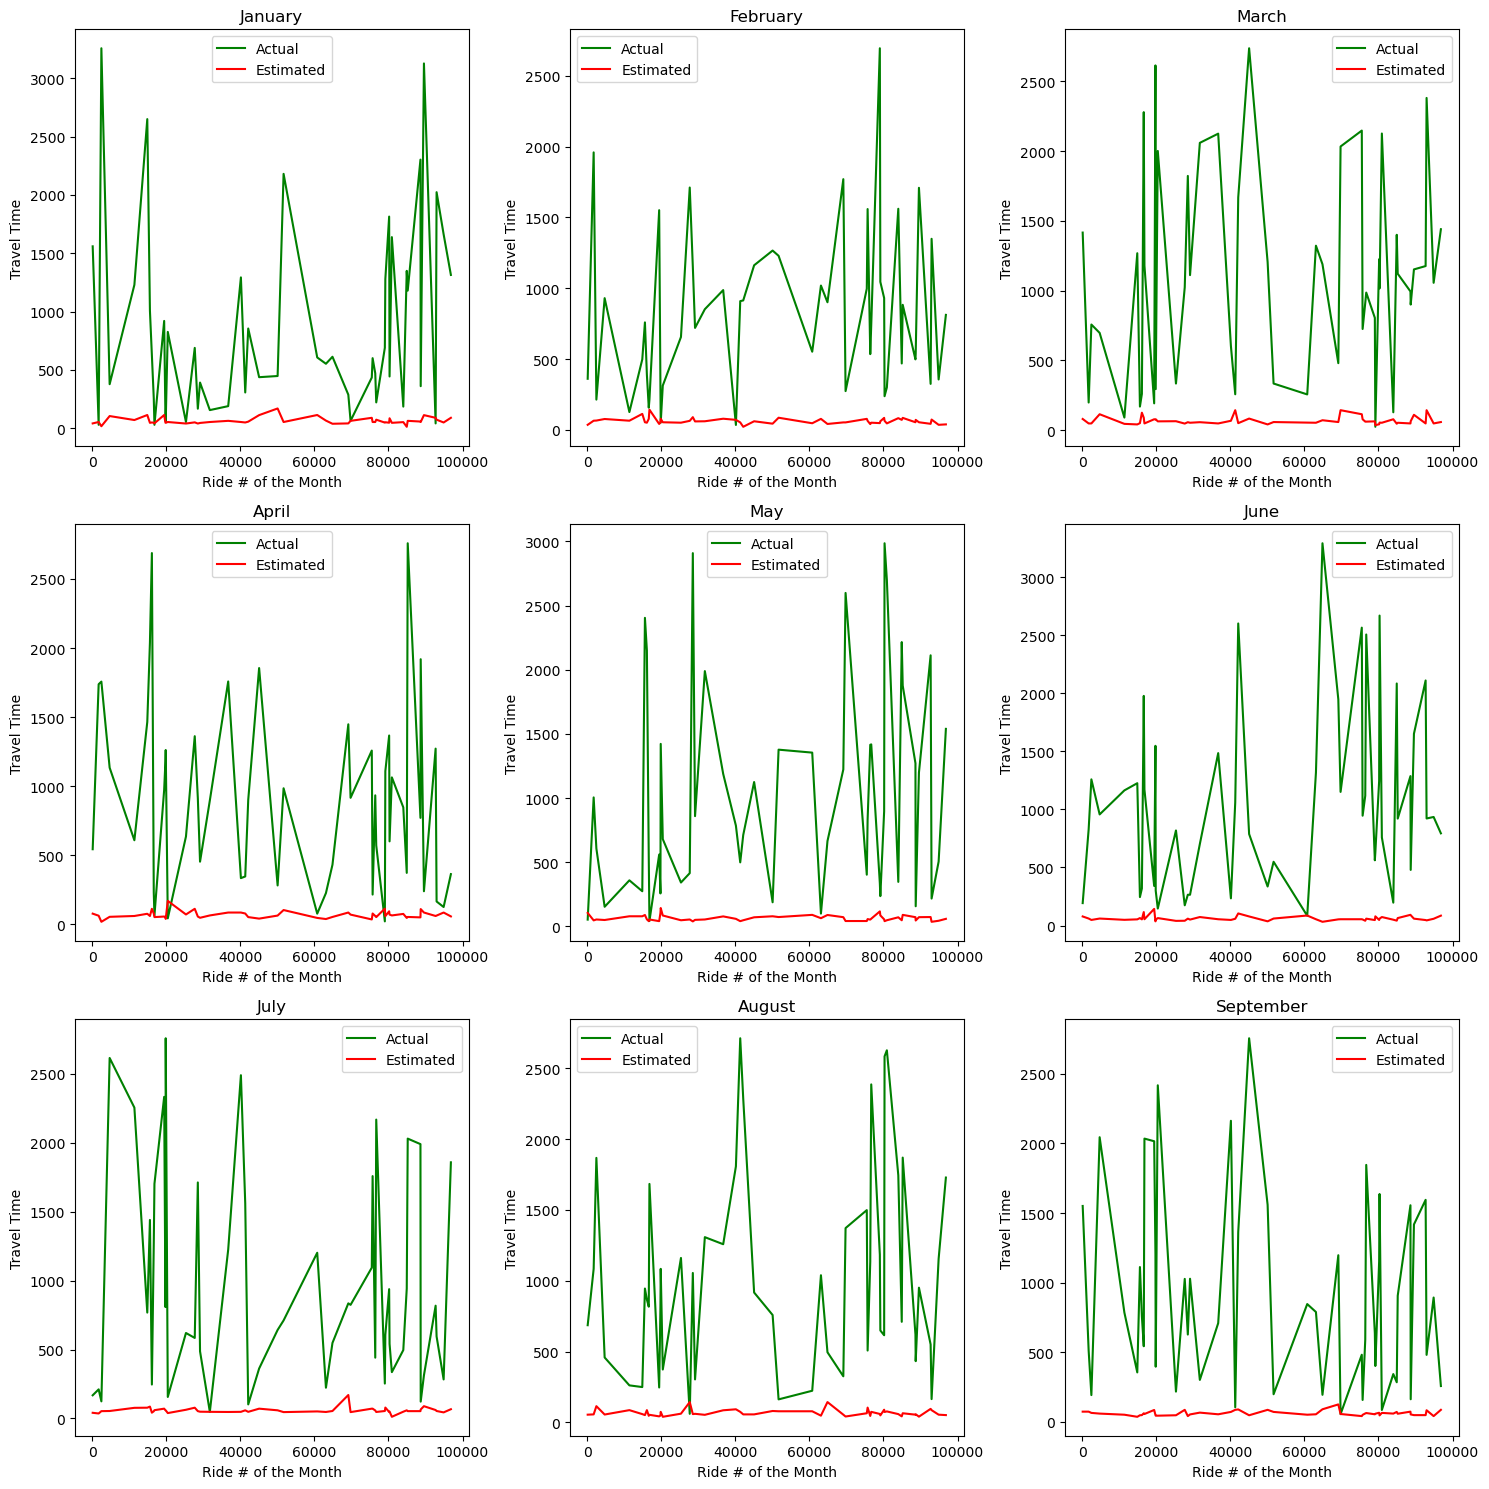

In [14]:
FILEPATH_ = "/Users/ytpatel3/Downloads/green_line_data/"
FILENAMES_ = [FILEPATH_ + "January_green_line_data.csv", FILEPATH_ + "February_green_line_data.csv", FILEPATH_ + "March_green_line_data.csv",
             FILEPATH_ + "April_green_line_data.csv", FILEPATH_ + "May_green_line_data.csv", FILEPATH_ + "June_green_line_data.csv",
             FILEPATH_ + "July_green_line_data.csv", FILEPATH_ + "August_green_line_data.csv", FILEPATH_ + "September_green_line_data.csv"]

data_dct2 = {}

for i in range(len(FILENAMES_)):
    data_dct2[MONTHS[i]] = pd.read_csv(FILENAMES_[i], low_memory=False).drop(columns=['Unnamed: 0'])

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, (month, df) in enumerate(data_dct2.items()):
    sampled_df = df.sample(n=50, random_state=42).sort_index()
    
    ax = axes[i // 3, i % 3]
    ax.plot(sampled_df.index, sampled_df['travel_time_sec'], label='Actual', color='green')
    ax.plot(sampled_df.index, sampled_df['estimated_travel_time_sec'], label='Estimated', color='red')
    ax.set_title(month)
    ax.set_xlabel('Ride # of the Month')
    ax.set_ylabel('Travel Time')
    ax.legend()

plt.tight_layout()
plt.show()
